In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from FeatureStatCalulateFile import FeatureStat

In [2]:

data = pd.read_csv('data/app_data.csv', index_col=False)
data['X'] = data['X'].astype(float)
data['Y'] = data['Y'].astype(float)
data['Z'] = data['Z'].astype(float)
data['Activity'] = data['Activity'].str.rstrip(';')
data['Activity'] = data['Activity'].str.strip()
# Clean the data
data = data.dropna(subset=['Activity'])  # Drop rows with missing activity
data['Z'] = pd.to_numeric(data['Z'], errors='coerce')  # Convert Z to numeric
data = data.dropna()  # Drop any rows with remaining NaN values

# Ensure 'Activity' is stripped of leading/trailing spaces
data['Activity'] = data['Activity'].str.strip()
corrections = {
    'Walkin': 'Walking',
    'Eating Popconr': 'Eating Popcorn'
}
data['Activity'] = data['Activity'].replace(corrections)

/var/folders/mn/35k8vrvj7z9046dsf_t68vzh0000gn/T/ipykernel_34282/2547746645.py:1: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  data = pd.read_csv('data/app_data.csv', index_col=False)


In [3]:
data['Activity'].value_counts()

Activity
Vaping            1459
Eating popcorn    1458
Typing            1216
Drinking Water    1215
Walking           1215
Sitting            244
Name: count, dtype: int64

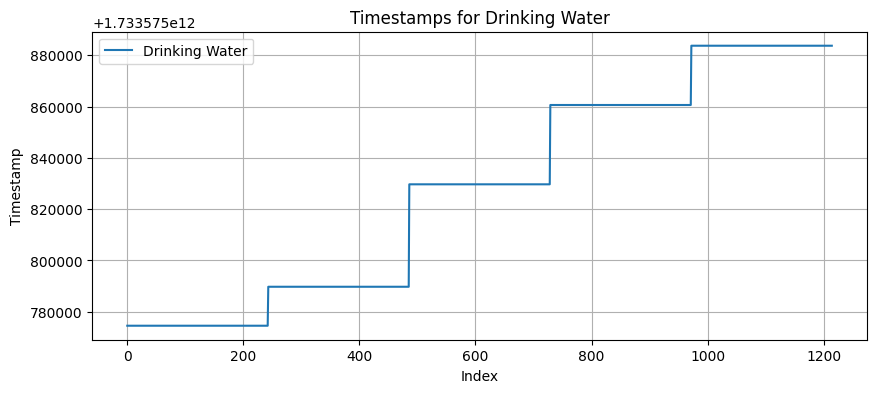

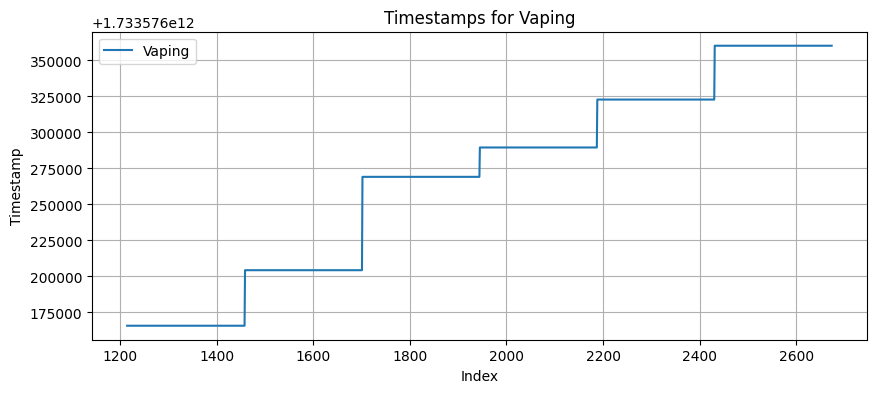

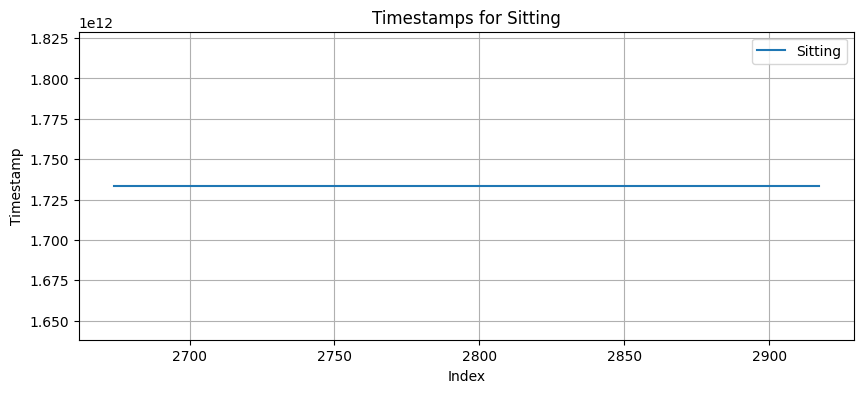

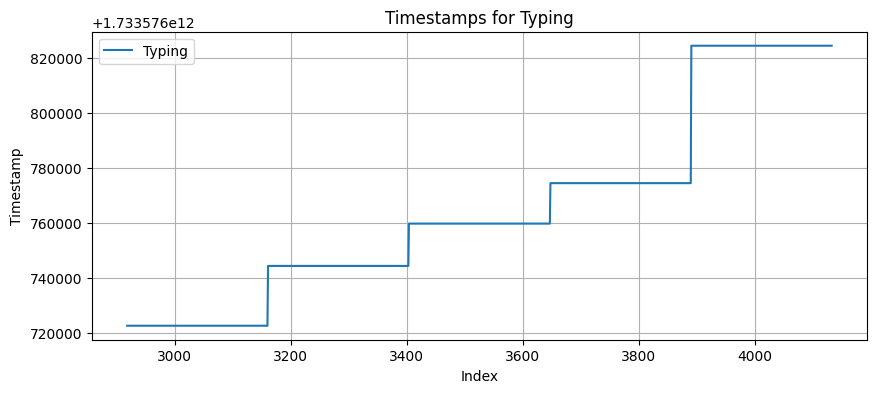

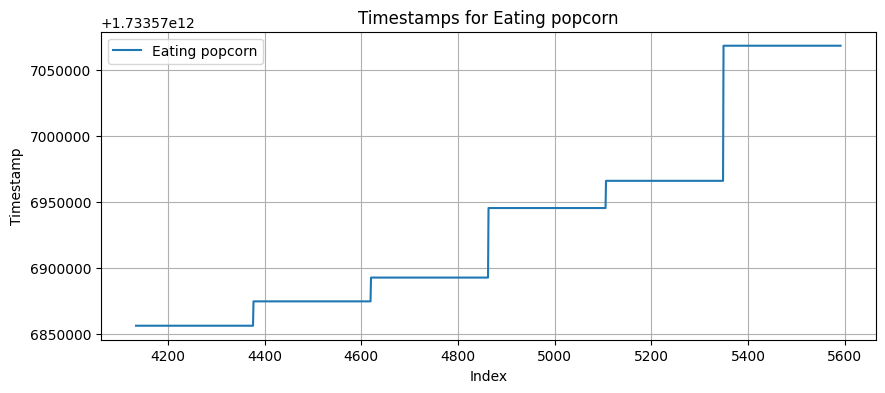

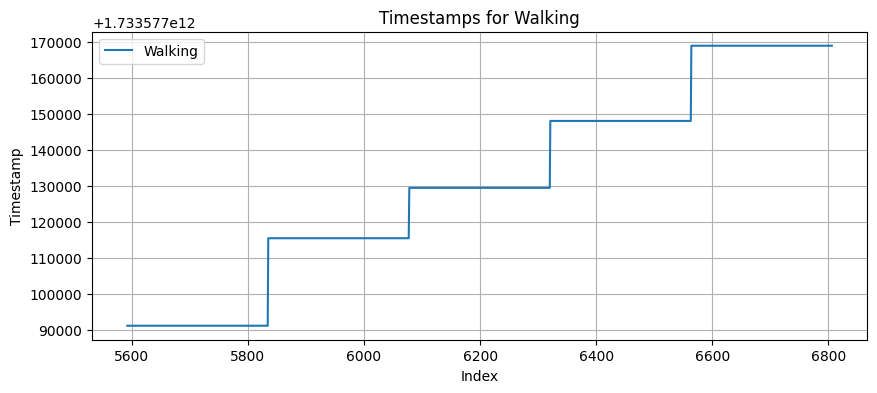

In [4]:
import matplotlib.pyplot as plt

for activity in data['Activity'].unique():
    subset = data[data['Activity'] == activity]
    plt.figure(figsize=(10, 4))
    plt.plot(subset['TimeStamp'], label=activity)
    plt.title(f"Timestamps for {activity}")
    plt.xlabel("Index")
    plt.ylabel("Timestamp")
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
# Balance the dataset by selecting a specific number of rows for each activity
drinking_water = data[data['Activity'] == 'Drinking Water'].head(1200)
vaping = data[data['Activity'] == 'Vaping'].head(1200)
typing = data[data['Activity'] == 'Typing'].head(1200)
eating_popcorn = data[data['Activity'] == 'Eating Popconr'].head(1200)
walking = data[data['Activity'] == 'Walking'].head(1200)

balanced_data = pd.DataFrame()
balanced_data = pd.concat([drinking_water, vaping, typing, eating_popcorn, walking])


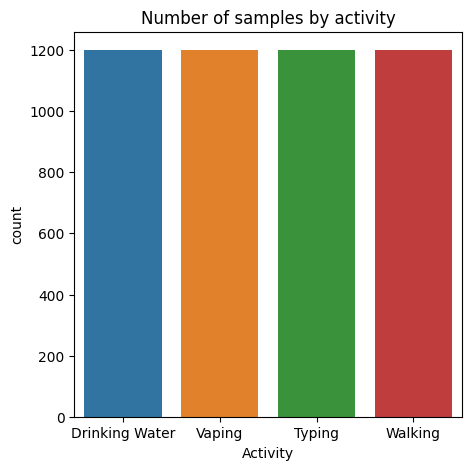

In [5]:
plt.figure(figsize=(5,5))
sns.countplot(x='Activity', data=balanced_data, hue='Activity')
plt.title('Number of samples by activity')
plt.show()

In [6]:
# create window sizes: 

def get_windows(df, window_size, step_size):

    x_list = []
    y_list = []
    z_list = []
    activity_list = []
    for i in range(0, df.shape[0] - window_size, step_size):
        xs = df['X'].values[i : i + window_size]
        ys = df['Y'].values[i : i + window_size]
        zs = df['Z'].values[i : i + window_size]
        label = df['Activity'][i : i + window_size].mode()[0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        activity_list.append(label)
    return x_list, y_list, z_list, activity_list

In [17]:
X = pd.DataFrame()
x_list, y_list, z_list, activity_list = get_windows(balanced_data, 200, 100)
featured_data = FeatureStat(X, x_list, y_list, z_list)
X = featured_data.all()

from sklearn.model_selection import train_test_split

y = pd.Series(activity_list)  # Corresponding labels

# Step 3: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify the splits
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Activities ", len(activity_list))


scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




Train set shape: (36, 59) (36,)
Test set shape: (10, 59) (10,)
Activities  46


In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
decisionTree = DecisionTreeClassifier(random_state=41)
cv_scores_dt = cross_val_score(decisionTree, X_train, y_train, cv=skf, scoring='accuracy')
decisionTree.fit(X_train, y_train)
dT_yPred = decisionTree.predict(X_test)
dT_accuracy = accuracy_score(y_test, dT_yPred)
print(f"Decision Tree Accuracy on test set: {dT_accuracy * 100:.2f}%")
print("Decision Tree Cross-Validation Scores:", cv_scores_dt)
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_dt) * 100:.2f}%")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test, dT_yPred))

Decision Tree Accuracy on test set: 60.00%
Decision Tree Cross-Validation Scores: [0.875      1.         1.         0.71428571 0.57142857]
Mean Cross-Validation Accuracy: 83.21%

Decision Tree Classification Report:
                precision    recall  f1-score   support

Drinking Water       0.50      0.33      0.40         3
        Typing       0.40      0.67      0.50         3
        Vaping       1.00      0.50      0.67         2
       Walking       1.00      1.00      1.00         2

      accuracy                           0.60        10
     macro avg       0.72      0.62      0.64        10
  weighted avg       0.67      0.60      0.60        10



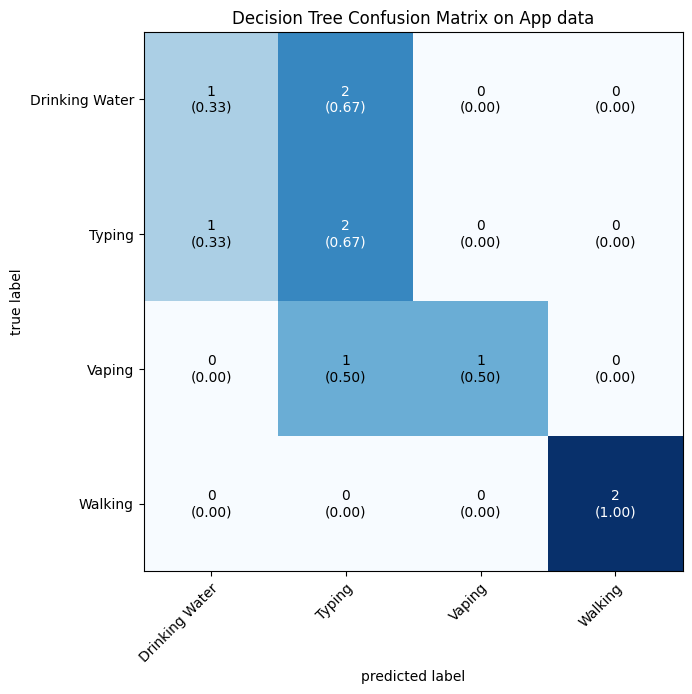

In [21]:
dT_cm = confusion_matrix(y_test, dT_yPred)
plot_confusion_matrix(dT_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Decision Tree Confusion Matrix on App data")
plt.show()

In [22]:
# Random Forest with Cross-Validation
randomForest = RandomForestClassifier(random_state=41)
cv_scores_rf = cross_val_score(randomForest, X_train, y_train, cv=skf, scoring='accuracy')
randomForest.fit(X_train, y_train)
rF_yPred = randomForest.predict(X_test)
rF_accuracy = accuracy_score(y_test, rF_yPred)

print(f"Random Forest Accuracy on test set: {rF_accuracy * 100:.2f}%")
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores_rf) * 100:.2f}%")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rF_yPred))

Random Forest Accuracy on test set: 80.00%
Random Forest Cross-Validation Scores: [0.75       1.         1.         0.85714286 0.85714286]
Mean Cross-Validation Accuracy: 89.29%

Random Forest Classification Report:
                precision    recall  f1-score   support

Drinking Water       0.60      1.00      0.75         3
        Typing       1.00      0.67      0.80         3
        Vaping       1.00      0.50      0.67         2
       Walking       1.00      1.00      1.00         2

      accuracy                           0.80        10
     macro avg       0.90      0.79      0.80        10
  weighted avg       0.88      0.80      0.80        10



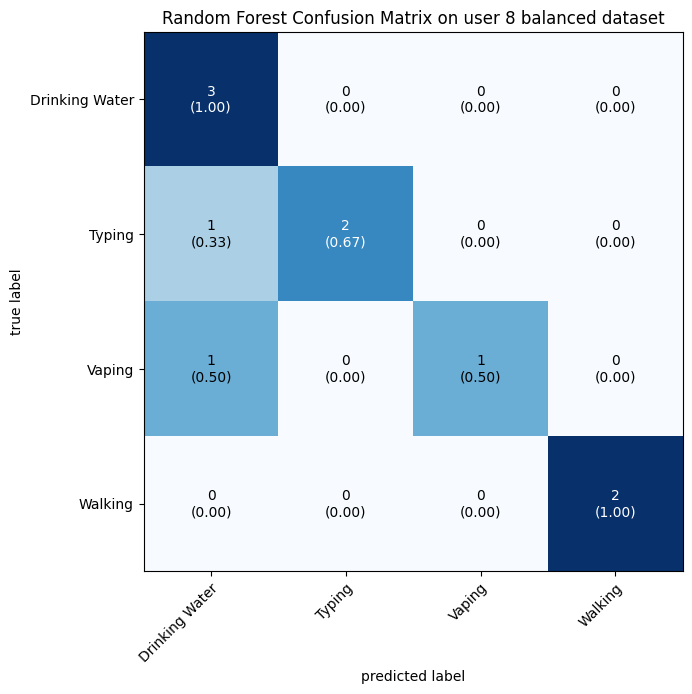

In [23]:
rF_cm = confusion_matrix(y_test, rF_yPred)
plot_confusion_matrix(rF_cm, class_names=decisionTree.classes_, show_normed=True, figsize=(7,7))
plt.title("Random Forest Confusion Matrix on user 8 balanced dataset")
plt.show()